In [276]:
# data manipulation
import pandas as pd
import numpy as np
import math
# model training
from sklearn.model_selection import GridSearchCV

# classifiers
from sklearn.naive_bayes import GaussianNB # naive bayes
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.svm import SVC # SVM
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.ensemble import BalancedBaggingClassifier

# machine learning models/techniques third parties 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.linear_model as sklm

# for final validation to plot ROC curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

from tensorflow import set_random_seed
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, Activation, MaxPool2D, Dropout, Flatten
from keras import optimizers, losses
from keras.models import model_from_json

from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest

# to time experiments
import time


# to calculate kurtosis and skew
from scipy.stats import kurtosis
from scipy.stats import skew

# for plots
import seaborn as sns 
import matplotlib as pl
import matplotlib.pyplot as plt

import dataexp as dtex # our code
import dataio as dtio # our code 
import preprocessing as pre # our code

# to display pandas and other elements in html
from IPython.display import display
from IPython.core.display import HTML
from IPython.display import Image

# for ordered dictionaries 
from collections import OrderedDict

# for feature extraction
import feature_extraction as fe # our code

# machine learning models/techniques
import model_validation as me # our code
#from decision_tree import DecisionTree # our code
#from random_forest import RandomForest # our code
from logistic_regression import LogisticRegression # our code


# from blagging import BlaggingClassifier
import fancyimpute
from missingpy import MissForest

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [277]:
x_train_o = pd.read_csv('financial_data.csv')
y_train_o = pd.read_csv('revealed_businesses.csv')

x_test_o = pd.read_csv("testing_data.csv")


In [278]:
x_train_o.replace('?', np.nan, inplace=True)
x_train_o = x_train_o.astype('float64')


x_test_o.replace('?', np.nan, inplace=True)
x_test_o = x_test_o.astype('float64')
#x_test_o.dtypes

,total_instances,total_instances_with_missing_values,total_instances_without_missing_values,data_loss
0,9003.0,4702.0,4301.0,0.5223


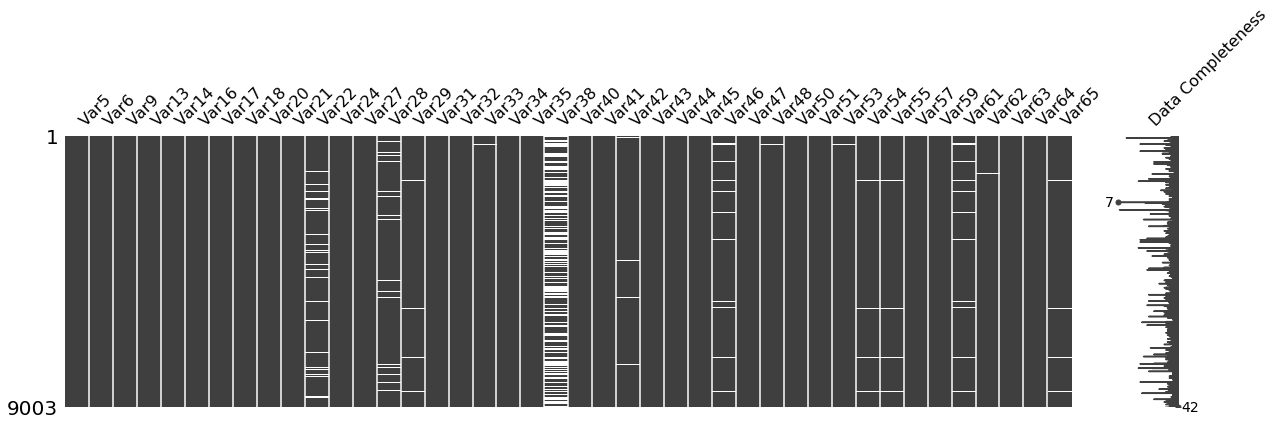

In [279]:
missing_stats_df = dtex.missing_stats(x_train_o)
display(missing_stats_df)

#nullity matrix
dtex.nullity_matrix([x_train_o], include_all = False)

#heatmap - nullity correlation
#dtex.nullity_heatmap([x_train_o], include_all = False)


In [280]:
data_train_all = x_train_o.merge(y_train_o, on='Var1', how = 'inner')
data_train_all_id = data_train_all['Var1']
data_train_all = data_train_all.drop(columns=['Var1'])
# x_train=data_train_all.drop(columns=['Var66'])
# y_train=data_train_all['Var66']

In [281]:
x_test_business_id = x_test_o['Var1']
x_test = x_test_o.drop(columns=['Var1'])

In [282]:
imp_mean_dfs = data_train_all.fillna(data_train_all.mean())
imp_mode_dfs = data_train_all.fillna(data_train_all.mode().iloc[0])


In [283]:
outlier_fraction

0.036101083032490974

In [284]:
outlier_fraction = data_train_all['Var66'].value_counts()[1]/float(data_train_all['Var66'].value_counts()[0])

In [285]:
imputer = MissForest()
imp_rf_dfs = imputer.fit_transform(data_train_all)
imp_rf_df = pd.DataFrame(data=imp_rf_dfs, columns=imp_mode_dfs.columns)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


In [286]:
imbalanced_stats_df = dtex.imbalanced_stats([imp_mode_dfs],'Var66')
display(imbalanced_stats_df)

,label_0,label_1,minortiy_label,minority_percentage
0,4709.0,170.0,1.0,0.034843


In [287]:
imp_mean_dfs.isnull().sum().sum()

0

In [288]:
os_dfs_dict = OrderedDict()

os_dfs_dict['mean'] = pre.oversample_smote(imp_mean_dfs, columns = imp_mean_dfs.columns, verbose=True)

os_dfs_dict['mode'] = pre.oversample_smote(imp_mode_dfs, columns = imp_mode_dfs.columns, verbose=True)
os_dfs_dict['rf'] = pre.oversample_smote(imp_rf_df, columns = imp_mean_dfs.columns, verbose=True)


original dataset (labels): {0: 4709, 1: 170}
total: 4879
resampled dataset (labels): {0: 4709, 1: 4709}
total: 9418

original dataset (labels): {0: 4709, 1: 170}
total: 4879
resampled dataset (labels): {0: 4709, 1: 4709}
total: 9418

original dataset (labels): {0.0: 4709, 1.0: 170}
total: 4879
resampled dataset (labels): {0.0: 4709, 1.0: 4709}
total: 9418



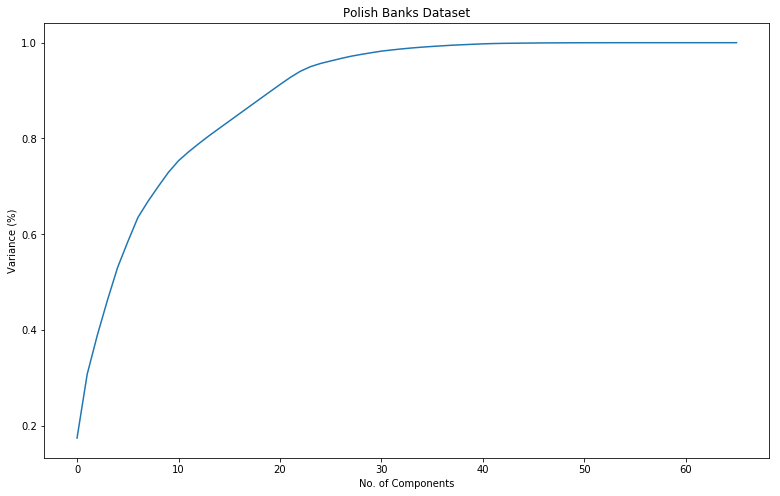

In [289]:
tmp_os_mean = os_dfs_dict['mean'][0]
#s_temp_os_mean = tmp_os_mean[tmp_os_mean.columns[:-1]].apply(pre.standardization, axis = 0)
s_tmp_os_mean = pd.DataFrame(preprocessing.StandardScaler().fit_transform(tmp_os_mean),columns = tmp_os_mean.columns)
s_tmp_os_mean_y = pd.concat([s_tmp_os_mean, tmp_os_mean.iloc[:,-1]], axis = 1)

# apply PCA 
s_tmp_os_mean_pca, pca_instance = fe.pca_reduction(s_tmp_os_mean_y) 

# plot components and variance 
plt.figure(figsize=(13,8))
com_var = np.cumsum(pca_instance.explained_variance_ratio_) 
plt.plot(com_var)
plt.xlabel("No. of Components")
plt.ylabel("Variance (%)")
plt.title("Polish Banks Dataset")
plt.show()


In [290]:
n_components = 29
pca_dfs_dict = OrderedDict()
for key in os_dfs_dict:
    tmp_dfs = []
    for i in range(len(os_dfs_dict[key])):
        # apply standardization to features 
        tmp_standard = os_dfs_dict[key][i][os_dfs_dict[key][i].columns[:-1]].apply(pre.standardization, axis = 0)
        # concat outcome and standardized features
        tmp_standard_y = pd.concat([tmp_standard, os_dfs_dict[key][i].iloc[:,-1]], axis = 1)
        
        # apply feature reduction using PCA (using the same instance)
        tmp_reduction, tmp_pca_instance = fe.pca_reduction(dataframes = tmp_standard_y, 
                                                           n_components = n_components) 
        
        # output components/variance
        tmp_com_var = np.cumsum(tmp_pca_instance.explained_variance_ratio_) 
        print("\tN Components: {0}\n\tWith total variance: {1}%\n\tFeatures removed: {2}"
              .format(n_components, round(tmp_com_var[n_components - 1],4), 
                      os_dfs_dict[key][0].shape[1] - n_components - 1))

        # append reduced features for specifc dataset 
        tmp_dfs.append(tmp_reduction[0])
    pca_dfs_dict[key] = tmp_dfs

	N Components: 29
	With total variance: 0.9786%
	Features removed: 35
	N Components: 29
	With total variance: 0.9786%
	Features removed: 35
	N Components: 29
	With total variance: 0.9793%
	Features removed: 35


In [291]:
n_tmp_os_mean = tmp_os_mean[tmp_os_mean.columns[:-1]].apply(pre.scale_range, args = (0,1), axis = 0)

# calculate chi squared scores 
feature_chi_score, feature_chi_columns = fe.chi2_scores(n_tmp_os_mean, tmp_os_mean.values[:,-1], tmp_os_mean.columns[:-1])

# since we will be comparing PCA and feature selection take top 29 (n_components) features
top_feature_chi_columns = feature_chi_columns[:n_components]
print("[Chi Squared Feature Selection]\n\nTop {0} features selected {1}\n".format(n_components, 
                                                                                  top_feature_chi_columns))

# print all feature chi score 
for i in range(len(feature_chi_score)):
    print("{0}: {1}".format(feature_chi_score[i][0], round(feature_chi_score[i][1], 4)))

[Chi Squared Feature Selection]

Top 29 features selected ['Var3', 'Var52', 'Var64', 'Var38', 'Var34', 'Var65', 'Var62', 'Var48', 'Var51', 'Var61', 'Var25', 'Var63', 'Var22', 'Var18', 'Var42', 'Var9', 'Var53', 'Var4', 'Var11', 'Var26', 'Var59', 'Var30', 'Var36', 'Var8', 'Var15', 'Var19', 'Var12', 'Var2', 'Var23']

Var3: 9.9184
Var52: 9.4779
Var64: 5.4706
Var38: 3.323
Var34: 2.4683
Var65: 1.8126
Var62: 1.1332
Var48: 0.9934
Var51: 0.9736
Var61: 0.8324
Var25: 0.4601
Var63: 0.3986
Var22: 0.3885
Var18: 0.3771
Var42: 0.3601
Var9: 0.3371
Var53: 0.2961
Var4: 0.2847
Var11: 0.2562
Var26: 0.2486
Var59: 0.2403
Var30: 0.2365
Var36: 0.2027
Var8: 0.1922
Var15: 0.1922
Var19: 0.1922
Var12: 0.184
Var2: 0.1783
Var23: 0.1721
Var21: 0.1493
Var39: 0.1457
Var44: 0.1194
Var45: 0.1111
Var35: 0.0895
Var17: 0.0623
Var27: 0.061
Var29: 0.0426
Var10: 0.0412
Var47: 0.0388
Var56: 0.0376
Var49: 0.0297
Var41: 0.026
Var33: 0.0243
Var60: 0.0204
Var13: 0.0186
Var58: 0.013
Var37: 0.009
Var16: 0.0082
Var5: 0.0059
Var7: 0.00

In [292]:
# initialize a new Ordered dicionary to hold feature selected datasets 
chi2_dfs_dict = OrderedDict()

# concat top columns with outcome column
tmp_feature_chi_columns = np.concatenate((top_feature_chi_columns,["Var66"]), axis=0)

# loop oversampled datasets 
for key in os_dfs_dict:
    tmp_dfs = []
    
    # loop in every dataset for each imputation technique
    for i in range(len(os_dfs_dict[key])):
        
        # get selected features 
        tmp_df = os_dfs_dict[key][i][tmp_feature_chi_columns]
        
        # append to list 
        tmp_dfs.append(tmp_df)
        
    # assign list of dfs in dictionary using imputation technique as a key  
    chi2_dfs_dict[key] = tmp_dfs

In [293]:
# initialize logistic regression
rfe_log_reg = LogisticRegression(alpha = 0.01, lambda_t = 0.1)

# calculate RFE rankings  
feature_rfe_rank, feature_rfe_columns = fe.rfe_ranking(x = n_tmp_os_mean, 
                                                       y = tmp_os_mean.values[:,-1], 
                                                       estimator = rfe_log_reg, 
                                                       f = n_components, 
                                                       keys = tmp_os_mean.columns[:-1], 
                                                       step = 0.1)

# since we will be comparing with PCA and feature selection take top 29 (n_components) features
top_feature_rfe_columns = feature_rfe_columns[:n_components]
print("[RFE (LogReg) Feature Selection]\n\nTop {0} features selected {1}\n".format(n_components, 
                                                                                   top_feature_rfe_columns))


# print all feature rfe ranking 
for i in range(len(feature_rfe_rank)):
    print("{0}: {1}".format(feature_rfe_rank[i][0], round(feature_rfe_rank[i][1], 4)))

[RFE (LogReg) Feature Selection]

Top 29 features selected ['Var5', 'Var21', 'Var22', 'Var28', 'Var42', 'Var47', 'Var9', 'Var18', 'Var33', 'Var53', 'Var59', 'Var61', 'Var7', 'Var41', 'Var44', 'Var45', 'Var48', 'Var63', 'Var13', 'Var16', 'Var17', 'Var27', 'Var35', 'Var37', 'Var10', 'Var31', 'Var46', 'Var54', 'Var55']

Var5: 7
Var21: 7
Var22: 7
Var28: 7
Var42: 7
Var47: 7
Var9: 6
Var18: 6
Var33: 6
Var53: 6
Var59: 6
Var61: 6
Var7: 5
Var41: 5
Var44: 5
Var45: 5
Var48: 5
Var63: 5
Var13: 4
Var16: 4
Var17: 4
Var27: 4
Var35: 4
Var37: 4
Var10: 3
Var31: 3
Var46: 3
Var54: 3
Var55: 3
Var58: 3
Var29: 2
Var49: 2
Var51: 2
Var56: 2
Var60: 2
Var2: 1
Var3: 1
Var4: 1
Var6: 1
Var8: 1
Var11: 1
Var12: 1
Var14: 1
Var15: 1
Var19: 1
Var20: 1
Var23: 1
Var24: 1
Var25: 1
Var26: 1
Var30: 1
Var32: 1
Var34: 1
Var36: 1
Var38: 1
Var39: 1
Var40: 1
Var43: 1
Var50: 1
Var52: 1
Var57: 1
Var62: 1
Var64: 1
Var65: 1


In [294]:
# initialize a new Ordered dicionary to hold feature selected datasets 
rfe_dfs_dict = OrderedDict()
    
# concat top columns with outcome column
tmp_feature_rfe_columns = np.concatenate((top_feature_rfe_columns,["Var66"]), axis=0)

# loop oversampled datasets 
for key in os_dfs_dict:
    tmp_dfs = []
    
    # loop in every dataset for each imputation technique
    for i in range(len(os_dfs_dict[key])):
        
        # get selected features 
        tmp_df = os_dfs_dict[key][i][tmp_feature_rfe_columns]
        
        # append to list 
        tmp_dfs.append(tmp_df)
        
    # assign list of dfs in dictionary using imputation technique as a key  
    rfe_dfs_dict[key] = tmp_dfs

In [295]:


#parameters
exp_k_fold = 5


In [296]:
# initialize decision tree classifier (sklearn)
decision_tree_classifier_sklearn = DecisionTreeClassifier(criterion="gini")

# initialize random forest classifier (sklearn)
random_forest_classifier_sklearn = RandomForestClassifier(criterion="gini", 
                                                          n_estimators = 10,
                                                          max_features = "sqrt", 
                                                          random_state = 94)

# initialize logistic regression classifier (sklearn)
log_reg_classifier_sklearn = sklm.LogisticRegression(C = 0.1, 
                                                     max_iter = 1000,
                                                     penalty="l2", 
                                                     solver="sag", 
                                                     random_state = 94)


# BalancedBaggingClassifier
bb_classifier = BalancedBaggingClassifier(base_estimator = RandomForestClassifier(criterion='gini'), 
                                          n_estimators = 15, bootstrap = True)


# eXtreme Gradient Boosting Classifier (XGBClassifier)
#xgb_classifier = XGBClassifier()

#isolation forest classifier
if_classifier = IsolationForest(n_estimators=100, max_samples=imp_mean_dfs.shape[0], 
                                       contamination=outlier_fraction,random_state=94)

# creating ordered dictionary for all different models (sklearn)
models_dict_sklearn = OrderedDict()
# models_dict_sklearn["Decision Tree Sklearn"] = (decision_tree_classifier_sklearn, False)
models_dict_sklearn["Random Forest Sklearn"] = (random_forest_classifier_sklearn, False)
# models_dict_sklearn["Logistic Regression Sklearn"] = (log_reg_classifier_sklearn, True)
models_dict_sklearn["BalancedBaggingClassifier"] = (bb_classifier, False)
models_dict_sklearn["XGBClassifier"] = (xgb_classifier, False)

# models_dict_sklearn["isolationForestClassifier"] = (if_classifier, False)



# initialize dictionary to hold results for each experiment (sklearn)
experiments_dict_sklearn = OrderedDict()

In [297]:
#imputed oversampled dataset
start_time = time.time()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # applying experiment 1 and gathering results 
    experiment_1_sklearn = me.data_modeling(classifiers = models_dict_sklearn, 
                                    datasets = os_dfs_dict, 
                                    k = exp_k_fold,
                                    transform_func = pre.scale_range,
                                    transform_axis = 0,
                                    transform_func_args = (0,2),
                                    verbose = True)

    # add results to dictionary 
    experiments_dict_sklearn["Imputed Oversampled Datasets"] = experiment_1_sklearn

print("--- %s seconds ---" % (time.time() - start_time))

Model: Random Forest Sklearn
	Dataset: mean
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: mode
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: rf
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
Model: BalancedBaggingClassifier
	Dataset: mean
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: mode
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: rf
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
Model: XGBClassifier
	Dataset: mean
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: mode
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: rf
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
--- 186.932722

In [298]:
#PCA
start_time = time.time()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # applying experiment 2 and gathering results
    experiment_2_sklearn = me.data_modeling(classifiers = models_dict_sklearn, 
                                    datasets = pca_dfs_dict, 
                                    k = exp_k_fold,
                                    transform_func = pre.scale_range,
                                    transform_axis = 0,
                                    transform_func_args = (0,1),
                                    verbose = True)

    # add results to dictionary 
    experiments_dict_sklearn["PCA Datasets"] = experiment_2_sklearn
    
print("--- %s seconds ---" % (time.time() - start_time))

Model: Random Forest Sklearn
	Dataset: mean
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: mode
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: rf
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
Model: BalancedBaggingClassifier
	Dataset: mean
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: mode
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: rf
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
Model: XGBClassifier
	Dataset: mean
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: mode
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: rf
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
--- 113.192411

In [299]:
#chi
start_time = time.time()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # applying experiment 3 and gathering results
    experiment_3_sklearn = me.data_modeling(classifiers = models_dict_sklearn, 
                                    datasets = chi2_dfs_dict, 
                                    k = exp_k_fold,
                                    transform_func = pre.scale_range,
                                    transform_axis = 0,
                                    transform_func_args = (0,1),
                                    verbose = True)

    # add results to dictionary 
    experiments_dict_sklearn["Chi2 Datasets"] = experiment_3_sklearn

print("--- %s seconds ---" % (time.time() - start_time))

Model: Random Forest Sklearn
	Dataset: mean
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: mode
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: rf
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
Model: BalancedBaggingClassifier
	Dataset: mean
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: mode
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: rf
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
Model: XGBClassifier
	Dataset: mean
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: mode
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: rf
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
--- 110.028576

In [300]:
#RFE
start_time = time.time()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # applying experiment 4 and gathering results
    experiment_4_sklearn = me.data_modeling(classifiers = models_dict_sklearn, 
                                    datasets = rfe_dfs_dict, 
                                    k = exp_k_fold,
                                    transform_func = pre.scale_range,
                                    transform_axis = 0,
                                    transform_func_args = (0,1),
                                    verbose = True)

    # add results to dictionary 
    experiments_dict_sklearn["RFE Datasets"] = experiment_4_sklearn

print("--- %s seconds ---" % (time.time() - start_time))

Model: Random Forest Sklearn
	Dataset: mean
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: mode
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: rf
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
Model: BalancedBaggingClassifier
	Dataset: mean
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: mode
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: rf
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
Model: XGBClassifier
	Dataset: mean
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: mode
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: rf
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
--- 111.144113

In [301]:
# function which outputs results for each experiment conducted and parse into dictionary of dataframes
def parse_results(experiments, verbose = True):
    
    # parsed results 
    parsed_results = OrderedDict()
    
    # keeps track of the experiment number
    experiment_counter = 1
    
    # loop in each experiment
    for exp_key, exp_value in experiments.items():
        
        if verbose == True:
            print("###############################################################")
            print("\nExperiment No.{0}: [{1}]\n".format(experiment_counter, exp_key))

        # increment experiment counter 
        experiment_counter += 1
        
        # model results
        model_results = OrderedDict()
        counter = 0

        w, h = 12, 9;
        metric_stats = [[0 for x in range(w)] for y in range(h)] 
            
        # loop through each model 
        for model_key, model_value in exp_value.items():
            
            model_dataframes = []
            
            if verbose == True:
                print("\tModel: {0}\n".format(model_key))
            
            # loop through each imputation technique 
            for imp_key, imp_value in model_value.items():
                
                if verbose == True:
                    print("\t\tImputation Technique: {0}\n".format(imp_key))
                
                
                # loop through each dataset 
                for dataset_key, dataset_value in imp_value.items():
                    
                    metric_stats[counter][0] = "{0}_year{1}_{2}".format(imp_key, 3, model_key)
                    
                    if verbose == True:
                        print("\t\t\tDataset: year_{0}\n".format(dataset_key))
                                        
                    # get different metrics 
                    accuracy = round(dataset_value["Accuracy"] * 100, 4) 
                    metric_stats[counter][1] = accuracy

                    accuracy_str = str(accuracy) + "%"
                    recall = dataset_value["Recall"]
                    metric_stats[counter][2] = np.round(recall, 3)

                    precision = dataset_value["Precision"]
                    metric_stats[counter][3] = np.round(precision, 3)

                    f1score = dataset_value["F1 Score"]
                    metric_stats[counter][4] = np.round(f1score, 3)
                    
                    # confusion matrix
                    t_n = dataset_value["True Negative"]
                    metric_stats[counter][5] = t_n

                    f_p = dataset_value["False Postive"]
                    metric_stats[counter][6] = f_p

                    f_n = dataset_value["False Negative"]
                    metric_stats[counter][7] = f_n
                    
                    t_p = dataset_value["True Postive"]
                    metric_stats[counter][8] = t_p
                    # sensitivity
                    metric_stats[counter][9] = t_p/(t_p + f_n)
                    
                    # specificity
                    metric_stats[counter][10] = t_n/(f_p + t_n)
                    
                    # g-mean
                    metric_stats[counter][11] = math.sqrt(metric_stats[counter][9] + metric_stats[counter][10])
                    
                    counter = counter + 1 
                    
                    if verbose == True:
                        print("\t\t\t\tAccuarcy: {0}\n\t\t\t\tRecall: {1} \n\t\t\t\tPrecision: {2} \n\t\t\t\tF1 Score: {3}\n"
                              .format(accuracy_str, recall, precision,f1score))
                        print("\t\t\t\tTrue Negative: {0}\n\t\t\t\tFalse Postive: {1} \n\t\t\t\tFalse Negative: {2}\n\t\t\t\tTrue Postive: {2}\n"
                              .format(t_n, f_p, f_n, t_p))
                                    
            df_missing_stats = pd.DataFrame(data = metric_stats)
            model_dataframes.append(df_missing_stats)
            
            parsed_results[exp_key] = model_dataframes
        
    return parsed_results
                 
#parsed_results = parse_results(experiments_dict, verbose = False)
parsed_results_sklearn = parse_results(experiments_dict_sklearn, verbose = False)

In [302]:
def show_results(results_dict):
    for results_key, results_values in results_dict.items():
        print("Experiment: {0}".format(results_key))

        for dataframe in results_values:
            dataframe.columns = ["Type" , "Accuracy", "Recall", "Precision", "F1 Score", "True Negative", "False Postive","False Negative", "True Postive", 'sensitivity', 'specificity', "G-mean"]
            display(dataframe)
            
#show_results(parsed_results)
show_results(parsed_results_sklearn)

Experiment: Imputed Oversampled Datasets


,Type,Accuracy,Recall,Precision,F1 Score,True Negative,False Postive,False Negative,True Postive,sensitivity,specificity,G-mean
0,mean_year3_Random Forest Sklearn,98.5029,"[0.986, 0.984]","[0.984, 0.986]","[0.985, 0.985]",929.0,12.8,15.4,926.4,0.983648,0.986409,1.403587
1,mode_year3_Random Forest Sklearn,96.8464,"[0.965, 0.972]","[0.972, 0.965]","[0.968, 0.969]",908.8,33.0,26.4,915.4,0.971969,0.964961,1.391736
2,rf_year3_Random Forest Sklearn,96.8359,"[0.967, 0.97]","[0.97, 0.967]","[0.968, 0.968]",910.6,31.2,28.4,913.4,0.969845,0.966872,1.391660
3,mean_year3_BalancedBaggingClassifier,98.9594,"[0.983, 0.996]","[0.996, 0.983]","[0.99, 0.99]",925.8,16.0,3.6,938.2,0.996178,0.983011,1.406836
4,mode_year3_BalancedBaggingClassifier,97.6959,"[0.961, 0.993]","[0.993, 0.962]","[0.977, 0.977]",905.2,36.6,6.8,935.0,0.992780,0.961138,1.397826
5,rf_year3_BalancedBaggingClassifier,97.5260,"[0.958, 0.993]","[0.993, 0.959]","[0.975, 0.976]",901.8,40.0,6.6,935.2,0.992992,0.957528,1.396610
6,mean_year3_XGBClassifier,97.0695,"[0.963, 0.979]","[0.978, 0.963]","[0.97, 0.971]",906.8,35.0,20.2,921.6,0.978552,0.962837,1.393337
7,mode_year3_XGBClassifier,93.3320,"[0.894, 0.973]","[0.97, 0.902]","[0.931, 0.936]",842.0,99.8,25.8,916.0,0.972606,0.894033,1.366250
8,rf_year3_XGBClassifier,93.7672,"[0.902, 0.974]","[0.972, 0.908]","[0.935, 0.94]",849.0,92.8,24.6,917.2,0.973880,0.901465,1.369432


Experiment: PCA Datasets


,Type,Accuracy,Recall,Precision,F1 Score,True Negative,False Postive,False Negative,True Postive,sensitivity,specificity,G-mean
0,mean_year3_Random Forest Sklearn,94.5849,"[0.942, 0.95]","[0.95, 0.942]","[0.946, 0.946]",887.0,54.8,47.2,894.6,0.949883,0.941814,1.375390
1,mode_year3_Random Forest Sklearn,93.0771,"[0.926, 0.935]","[0.934, 0.927]","[0.93, 0.931]",872.6,69.2,61.2,880.6,0.935018,0.926524,1.364383
2,rf_year3_Random Forest Sklearn,92.2064,"[0.918, 0.926]","[0.926, 0.918]","[0.922, 0.922]",864.4,77.4,69.4,872.4,0.926311,0.917817,1.357987
3,mean_year3_BalancedBaggingClassifier,95.6998,"[0.935, 0.979]","[0.978, 0.938]","[0.956, 0.958]",880.8,61.0,20.0,921.8,0.978764,0.935230,1.383472
4,mode_year3_BalancedBaggingClassifier,93.4806,"[0.901, 0.968]","[0.966, 0.908]","[0.933, 0.937]",849.0,92.8,30.0,911.8,0.968146,0.901465,1.367337
5,rf_year3_BalancedBaggingClassifier,93.6185,"[0.907, 0.965]","[0.963, 0.912]","[0.934, 0.938]",854.2,87.6,32.6,909.2,0.965385,0.906987,1.368346
6,mean_year3_XGBClassifier,87.7362,"[0.826, 0.928]","[0.92, 0.843]","[0.871, 0.883]",778.4,163.4,67.6,874.2,0.928223,0.826502,1.324660
7,mode_year3_XGBClassifier,82.5546,"[0.759, 0.892]","[0.875, 0.788]","[0.813, 0.836]",715.2,226.6,102.0,839.8,0.891697,0.759397,1.284949
8,rf_year3_XGBClassifier,82.6077,"[0.759, 0.894]","[0.877, 0.787]","[0.813, 0.837]",714.4,227.4,100.2,841.6,0.893608,0.758547,1.285362


Experiment: Chi2 Datasets


,Type,Accuracy,Recall,Precision,F1 Score,True Negative,False Postive,False Negative,True Postive,sensitivity,specificity,G-mean
0,mean_year3_Random Forest Sklearn,95.6254,"[0.954, 0.959]","[0.959, 0.954]","[0.956, 0.956]",898.0,43.8,38.6,903.2,0.959015,0.953493,1.382935
1,mode_year3_Random Forest Sklearn,94.5105,"[0.942, 0.948]","[0.948, 0.942]","[0.945, 0.945]",887.2,54.6,48.8,893.0,0.948184,0.942026,1.374849
2,rf_year3_Random Forest Sklearn,94.5104,"[0.94, 0.95]","[0.95, 0.941]","[0.945, 0.945]",885.4,56.4,47.0,894.8,0.950096,0.940115,1.374849
3,mean_year3_BalancedBaggingClassifier,96.1775,"[0.94, 0.983]","[0.982, 0.943]","[0.961, 0.963]",885.6,56.2,15.8,926.0,0.983224,0.940327,1.386921
4,mode_year3_BalancedBaggingClassifier,95.7528,"[0.934, 0.981]","[0.98, 0.937]","[0.956, 0.959]",879.8,62.0,18.0,923.8,0.980888,0.934169,1.383856
5,rf_year3_BalancedBaggingClassifier,95.7316,"[0.933, 0.982]","[0.981, 0.936]","[0.956, 0.958]",878.2,63.6,16.8,925.0,0.982162,0.932470,1.383702
6,mean_year3_XGBClassifier,89.0847,"[0.875, 0.907]","[0.904, 0.879]","[0.889, 0.893]",823.6,118.2,87.4,854.4,0.907199,0.874496,1.334801
7,mode_year3_XGBClassifier,87.5560,"[0.834, 0.918]","[0.91, 0.847]","[0.87, 0.881]",785.2,156.6,77.8,864.0,0.917392,0.833723,1.323297
8,rf_year3_XGBClassifier,87.7044,"[0.838, 0.915]","[0.909, 0.85]","[0.872, 0.881]",789.6,152.2,79.4,862.4,0.915693,0.838395,1.324420


Experiment: RFE Datasets


,Type,Accuracy,Recall,Precision,F1 Score,True Negative,False Postive,False Negative,True Postive,sensitivity,specificity,G-mean
0,mean_year3_Random Forest Sklearn,98.0463,"[0.979, 0.981]","[0.982, 0.979]","[0.98, 0.98]",922.4,19.4,17.4,924.4,0.981525,0.979401,1.400331
1,mode_year3_Random Forest Sklearn,96.2731,"[0.962, 0.964]","[0.964, 0.962]","[0.963, 0.963]",905.6,36.2,34.0,907.8,0.963899,0.961563,1.387610
2,rf_year3_Random Forest Sklearn,95.9652,"[0.957, 0.963]","[0.963, 0.957]","[0.96, 0.96]",900.8,41.0,35.0,906.8,0.962837,0.956466,1.385389
3,mean_year3_BalancedBaggingClassifier,98.5984,"[0.979, 0.993]","[0.993, 0.979]","[0.986, 0.986]",921.6,20.2,6.2,935.6,0.993417,0.978552,1.404268
4,mode_year3_BalancedBaggingClassifier,97.0482,"[0.955, 0.986]","[0.986, 0.956]","[0.97, 0.971]",899.4,42.4,13.2,928.6,0.985984,0.954980,1.393185
5,rf_year3_BalancedBaggingClassifier,97.2924,"[0.954, 0.992]","[0.991, 0.956]","[0.972, 0.973]",898.8,43.0,8.0,933.8,0.991506,0.954343,1.394937
6,mean_year3_XGBClassifier,95.6361,"[0.955, 0.958]","[0.958, 0.955]","[0.956, 0.956]",899.2,42.6,39.6,902.2,0.957953,0.954767,1.383011
7,mode_year3_XGBClassifier,91.1764,"[0.873, 0.95]","[0.946, 0.883]","[0.908, 0.915]",822.6,119.2,47.0,894.8,0.950096,0.873434,1.350381
8,rf_year3_XGBClassifier,91.3358,"[0.877, 0.949]","[0.945, 0.886]","[0.91, 0.916]",826.4,115.4,47.8,894.0,0.949246,0.877469,1.351560


In [100]:
x_test_f = x_test.fillna(x_test.mean())

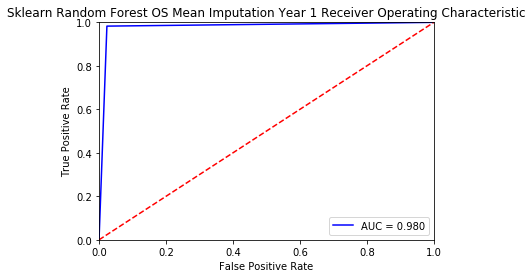

In [101]:
best_period = os_dfs_dict['mean'][0]
X = best_period.iloc[:,0:-1].values
y = best_period["Var66"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state= 42)

random_forest_classifier_sklearn_roc = RandomForestClassifier(criterion="gini", 
                                                          n_estimators = 10,
                                                          max_features = "sqrt", 
                                                          random_state = 94)

random_forest_classifier_sklearn_roc.fit(X_train, y_train)
y_pred_dt = random_forest_classifier_sklearn_roc.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred_dt)
roc_auc = auc(fpr, tpr)

plt.title('Sklearn Random Forest OS Mean Imputation Year 1 Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()




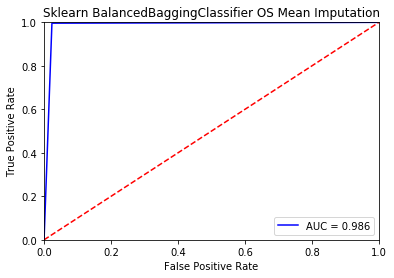

In [107]:
best_period = os_dfs_dict['mean'][0]
X = best_period.iloc[:,0:-1].values
y = best_period["Var66"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state= 42)

# BalancedBaggingClassifier
bb_classifier_roc = BalancedBaggingClassifier(base_estimator = RandomForestClassifier(criterion='gini'), 
                                          n_estimators = 15, bootstrap = True, random_state=42)
bb_classifier_roc.fit(X_train, y_train)
y_pred_dt = bb_classifier_roc.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred_dt)
roc_auc = auc(fpr, tpr)

plt.title('Sklearn BalancedBaggingClassifier OS Mean Imputation')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()




In [103]:
# random_forest_classifier_sklearn_roc_all = RandomForestClassifier(criterion="gini", 
#                                                           n_estimators = 10,
#                                                           max_features = "sqrt", 
#                                                           random_state = 94)

# random_forest_classifier_sklearn_roc_all.fit(X, y)
# y_pred_dt = random_forest_classifier_sklearn_roc_all.predict(x_test_f)

In [108]:
bb_classifier_roc_all = BalancedBaggingClassifier(base_estimator = RandomForestClassifier(criterion='gini'), 
                                          n_estimators = 15, bootstrap = True, random_state=42)

bb_classifier_roc_all.fit(X, y)
y_pred_dt = bb_classifier_roc_all.predict(x_test_f)

In [109]:
result = pd.DataFrame(y_pred_dt, columns=["Is_Bankrupted"])
upload = pd.concat([x_test_business_id, result], axis=1)
result["Is_Bankrupted"].value_counts()

0    1439
1      61
Name: Is_Bankrupted, dtype: int64

In [110]:
upload = upload.astype('int32')

In [111]:
upload.columns=['Business_ID', 'Is_Bankrupted']

In [113]:
upload.to_csv('3_18_1.csv', index=False)

In [114]:
upload.isnull().sum().sum()

0

In [125]:
df_acc_all = pd.merge(x_train_o, y_train_o, how='left', on='Var1')

In [138]:
df_null.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var57,Var58,Var59,Var60,Var61,Var62,Var63,Var64,Var65,Var66
1,15092.0,0.049699,0.065808,0.726800,12.94400,233.1100,0.00000,0.063192,14.19601,0.89618,...,0.059565,0.053189,0.93169,0.000000,5.0492,11.1520,24.784,14.7270,4.2204,NaN
3,14171.0,0.001417,0.708110,-0.052312,0.88978,-31.1980,0.26952,0.001407,0.41222,1.96540,...,-0.000535,0.004820,0.99930,0.745480,17.1011,7.9482,88.147,4.1408,3.4021,NaN
4,12900.0,0.020041,0.346520,0.335930,2.76130,39.0500,0.00000,0.020031,1.88591,1.29750,...,0.212410,0.030652,0.80158,0.000862,9.7670,6.7570,53.651,6.8032,2.7412,NaN
5,16499.0,0.140000,0.419930,0.290420,1.74160,7.1865,0.20062,0.177390,1.31961,1.10280,...,0.093230,0.252620,0.90677,0.051068,8.1696,5.1309,70.315,5.1909,6.3939,NaN
8,16122.0,0.094560,0.097575,0.422890,5.78220,82.3870,0.00000,0.108800,9.24851,1.27030,...,0.076875,0.104770,0.91846,0.000000,7.9041,4.5030,25.410,14.3650,2.5994,NaN


In [156]:
df_null = df_acc_all[df_acc_all['Var66'].isnull()]
df_null_id = df_null['Var1']
df_null_y = df_null[['Var1', 'Var66']]
df_null_features = df_null.drop(columns=['Var66'])

In [158]:
df_null_features.shape

(4124, 65)

In [159]:
imp_mean_df_null_features = df_null_features.fillna(df_null_features.mean())


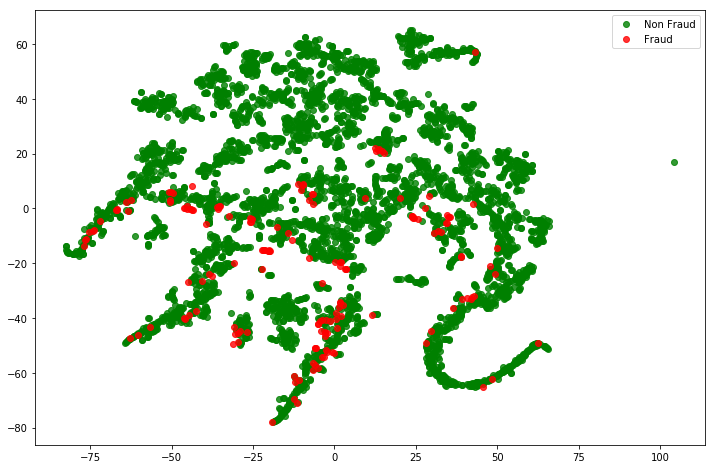

In [162]:
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

data_plot = x_train_o.merge(y_train_o, on='Var1', how = 'inner')

x1 = data_plot.drop(columns=['Var66'])


X = x1.fillna(x1.mean())
Y = data_plot['Var66']
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Notbankrupcy')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='bankrupcy')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
tsne_plot(X, Y, "original.png")

In [152]:
#os_dfs_dict['new_mean'] = pre.oversample_smote(imp_mean_df_null_features, columns = imp_mean_df_null_features.columns, verbose=True)



original dataset (labels): {-0.0001023: 1, 0.0: 10, 0.00017979: 1, 0.00021924: 1, 0.00027058: 1, 0.0012817: 1, 0.0023419: 1, 0.015175: 1, 0.035192: 1, 0.038198: 1, 0.038703: 1, 0.040943: 1, 0.043601: 1, 0.047978: 1, 0.053553: 1, 0.061957: 1, 0.06727: 1, 0.071996: 1, 0.072251: 1, 0.082778: 1, 0.085895: 1, 0.086424: 1, 0.087427: 1, 0.093273: 1, 0.10161: 1, 0.10174: 1, 0.10181: 1, 0.10316: 1, 0.12733: 1, 0.1284: 1, 0.13656: 1, 0.1405: 1, 0.14706: 1, 0.15597: 1, 0.15643: 1, 0.15836: 1, 0.16181: 1, 0.16465: 3, 0.17211: 1, 0.17311: 1, 0.17562: 1, 0.18155: 1, 0.18349: 1, 0.18619: 1, 0.18683: 1, 0.18894: 2, 0.19511: 1, 0.20557: 1, 0.20802: 1, 0.20918: 1, 0.2098: 1, 0.21019: 1, 0.21536: 1, 0.21625: 1, 0.21718: 1, 0.21845: 1, 0.21955: 1, 0.22236: 1, 0.22976: 1, 0.23611: 1, 0.23922: 1, 0.24071: 1, 0.24352: 1, 0.24358: 1, 0.24706: 1, 0.2474: 1, 0.25778: 1, 0.25781: 1, 0.26572: 1, 0.26635: 1, 0.2754: 1, 0.27798: 1, 0.2889: 1, 0.29416: 1, 0.29725: 1, 0.29895: 1, 0.30061: 1, 0.30748: 1, 0.30795: 1, 0

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 1, n_neighbors = 9